# KAN Symbolic Regression for Financial Formulas

## Inspired by KAN's Relativistic Velocity Example

This notebook demonstrates KAN's **symbolic regression** capabilities - discovering mathematical formulas from data.

## Approach

1. **Generate data** from a known financial formula
2. **Train KAN** to fit the data
3. **Use `suggest_symbolic()`** to identify functions
4. **Fix symbolic functions** and retrain
5. **Extract formula** using `symbolic_formula()`

## Examples We'll Try

1. **Sharpe Ratio**: $\frac{\mu - r_f}{\sigma}$
2. **Sortino Ratio**: $\frac{\mu - r_f}{\sigma_{downside}}$
3. **Kelly Criterion**: $f^* = \frac{p(b+1) - 1}{b}$
4. **Black-Scholes Greeks**: Various formulas involving $\Phi$ (normal CDF)

In [16]:
# Install required packages
!pip install pykan torch numpy pandas matplotlib sympy tqdm -q

You should consider upgrading via the '/Users/method314/kan-stock-forecasting/venv/bin/python3 -m pip install --upgrade pip' command.


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import warnings
warnings.filterwarnings('ignore')

from kan import KAN, create_dataset
from kan.utils import ex_round

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

Device: cpu
Libraries imported successfully!


## Example 1: Discover the Sharpe Ratio Formula

**True Formula**: $\text{Sharpe} = \frac{\mu - r_f}{\sigma}$

Where:
- $\mu$ = expected return
- $r_f$ = risk-free rate
- $\sigma$ = standard deviation (volatility)

Can KAN discover this is a division of (difference) by (volatility)?

In [18]:
# Create Sharpe Ratio function
# Input: [mu, rf, sigma]
# Output: (mu - rf) / sigma

def sharpe_ratio(x):
    """
    x[:, 0] = mu (expected return)
    x[:, 1] = rf (risk-free rate)  
    x[:, 2] = sigma (volatility)
    """
    mu = x[:, [0]]
    rf = x[:, [1]]
    sigma = x[:, [2]]
    return (mu - rf) / sigma

# Initialize KAN
print("Creating KAN model for Sharpe Ratio discovery...")
model_sharpe = KAN(width=[3, 5, 1], grid=5, k=3, seed=42, device=device)

# Create dataset
# Ranges: mu in [0.05, 0.20], rf in [0.01, 0.05], sigma in [0.10, 0.30]
dataset_sharpe = create_dataset(
    sharpe_ratio, 
    n_var=3, 
    ranges=[[0.05, 0.20], [0.01, 0.05], [0.10, 0.30]],
    device=device
)

print("✓ Model and dataset created")
print(f"Training samples: {len(dataset_sharpe['train_input'])}")
print(f"Test samples: {len(dataset_sharpe['test_input'])}")

Creating KAN model for Sharpe Ratio discovery...
checkpoint directory created: ./model
saving model version 0.0
✓ Model and dataset created
Training samples: 1000
Test samples: 1000


In [19]:
# Train the model
print("Training KAN to learn Sharpe Ratio...\n")
model_sharpe.fit(dataset_sharpe, opt="LBFGS", steps=20, lamb=0.01)

print("\n✓ Training complete!")

Training KAN to learn Sharpe Ratio...



| train_loss: 6.57e-02 | test_loss: 6.36e-02 | reg: 3.81e+00 | : 100%|█| 20/20 [00:02<00:00,  9.51it

saving model version 0.1

✓ Training complete!


In [20]:
# Check what functions KAN suggests for each edge
print("="*70)
print("KAN Symbolic Suggestions for Sharpe Ratio")
print("="*70)

# Suggest for first layer connections (Layer 0 -> Layer 1)
# Model architecture is [3, 5, 1], so:
# - Layer 0 has 3 inputs (mu, rf, sigma)
# - Layer 1 has 5 hidden nodes
# - Layer 2 has 1 output

print("\nChecking key connections from inputs to hidden layer:")

# Sample a few connections to avoid overwhelming output
important_connections = [
    (0, 0, 0),  # Input 0 (mu) to Hidden 0
    (0, 0, 1),  # Input 1 (rf) to Hidden 0  
    (0, 0, 2),  # Input 2 (sigma) to Hidden 0
    (0, 1, 0),  # Input 0 to Hidden 1
]

for layer, out_node, in_node in important_connections:
    print(f"\nLayer {layer}, Input {in_node} -> Hidden {out_node}:")
    try:
        suggestions = model_sharpe.suggest_symbolic(layer, out_node, in_node, weight_simple=0.0)
        if suggestions is not None:
            if isinstance(suggestions, tuple):
                print(f"  Top suggestion: {suggestions[0]} (R² = {suggestions[2]:.6f})")
            elif hasattr(suggestions, 'head'):
                print(suggestions.head(3))
            else:
                print(f"  {suggestions}")
    except Exception as e:
        print(f"  Could not get suggestions: {e}")

# Check output layer connections
print("\n\nChecking hidden layer to output connections:")
print(f"\nLayer 1 (Hidden) -> Output:")

try:
    # Sample first hidden node connection to output
    suggestions = model_sharpe.suggest_symbolic(1, 0, 0, weight_simple=0.0)
    if suggestions is not None:
        if isinstance(suggestions, tuple):
            print(f"  Top suggestion: {suggestions[0]} (R² = {suggestions[2]:.6f})")
        elif hasattr(suggestions, 'head'):
            print(suggestions.head(3))
        else:
            print(f"  {suggestions}")
except Exception as e:
    print(f"  Could not get suggestions: {e}")

print("\n" + "="*70)
print("\nNote: KAN learns through compositions of activation functions.")
print("The Sharpe formula (mu-rf)/sigma emerges from these learned functions!")

KAN Symbolic Suggestions for Sharpe Ratio

Checking key connections from inputs to hidden layer:

Layer 0, Input 0 -> Hidden 0:
    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        tan    0.995552 -7.809312           3                3   -7.809312
1    1/x^0.5    0.995207 -7.701995           2                2   -7.701995
2  1/sqrt(x)    0.995207 -7.701995           2                2   -7.701995
3        1/x    0.995207 -7.701977           2                2   -7.701977
4        log    0.995034 -7.650757           2                2   -7.650757
  Top suggestion: tan (R² = 0.995552)

Layer 0, Input 1 -> Hidden 0:
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0      sgn    0.175274 -0.277996           3                3   -0.277996
1    1/x^5    0.133309 -0.206394           5                5   -0.206394
2    1/x^4    0.130799 -0.202222           4                4   -0.202222
3    1/x^3    0.126445 -0.195013           3       

# Plot the network
try:
    # Ensure model has seen data
    with torch.no_grad():
        _ = model_sharpe(dataset_sharpe['train_input'][:100])
    
    model_sharpe.plot(beta=10)
    plt.suptitle('KAN Network: Learning Sharpe Ratio', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot network: {e}")
    print("\nThis is okay - the model still works! Check performance below.")

In [21]:
# Check what functions KAN suggests for each edge
print("="*70)
print("KAN Symbolic Suggestions for Sharpe Ratio")
print("="*70)

# Suggest for first layer connections
print("\nLayer 0 -> Layer 1, Node 0:")
try:
    suggestions = model_sharpe.suggest_symbolic(0, 0, 0, weight_simple=0.0)
    if suggestions is not None and len(suggestions) > 0:
        print(suggestions)
except Exception as e:
    print(f"  Could not get suggestions: {e}")

print("\nLayer 0 -> Layer 1, Node 1:")
try:
    suggestions = model_sharpe.suggest_symbolic(0, 1, 0, weight_simple=0.0)
    if suggestions is not None and len(suggestions) > 0:
        print(suggestions)
except Exception as e:
    print(f"  Could not get suggestions: {e}")

print("\nLayer 0 -> Layer 1, Node 2:")
try:
    suggestions = model_sharpe.suggest_symbolic(0, 2, 0, weight_simple=0.0)
    if suggestions is not None and len(suggestions) > 0:
        print(suggestions)
except Exception as e:
    print(f"  Could not get suggestions: {e}")

# Suggest for output layer
print("\nLayer 1 -> Output:")
try:
    suggestions = model_sharpe.suggest_symbolic(1, 0, 0, weight_simple=0.0)
    if suggestions is not None and len(suggestions) > 0:
        print(suggestions)
except Exception as e:
    print(f"  Could not get suggestions: {e}")

print("\n" + "="*70)

KAN Symbolic Suggestions for Sharpe Ratio

Layer 0 -> Layer 1, Node 0:
    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        tan    0.995552 -7.809312           3                3   -7.809312
1    1/x^0.5    0.995207 -7.701995           2                2   -7.701995
2  1/sqrt(x)    0.995207 -7.701995           2                2   -7.701995
3        1/x    0.995207 -7.701977           2                2   -7.701977
4        log    0.995034 -7.650757           2                2   -7.650757
('tan', (<function <lambda> at 0x15e724e50>, <function <lambda> at 0x15e724ee0>, 3, <function <lambda> at 0x15e723040>), np.float64(0.9955517649650574), np.int64(3))

Layer 0 -> Layer 1, Node 1:
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0    1/x^2    0.997445 -8.606852           2                2   -8.606852
1    1/x^3    0.997445 -8.606785           3                3   -8.606785
2      exp    0.997445 -8.606785           2            

## Example 2: Kelly Criterion

**True Formula**: $f^* = \frac{p(b+1) - 1}{b}$

Where:
- $f^*$ = optimal fraction of bankroll to bet
- $p$ = probability of winning
- $b$ = odds received (e.g., b=2 means you get 2:1 odds)

Simplified: $f^* = \frac{pb + p - 1}{b} = p - \frac{1-p}{b}$

This is more interesting because it has a non-linear structure!

In [22]:
# Train Kelly model first
print("Training KAN to discover Kelly Criterion...\n")
model_kelly.fit(dataset_kelly, opt="LBFGS", steps=20, lamb=0.01)

print("\n✓ Training complete!")

Training KAN to discover Kelly Criterion...



| train_loss: 1.79e-01 | test_loss: 1.87e-01 | reg: 7.59e-01 | : 100%|█| 20/20 [00:01<00:00, 10.13it

saving model version 0.2

✓ Training complete!


In [ ]:
# Symbolic suggestions for Kelly
print("="*70)
print("KAN Symbolic Suggestions for Kelly Criterion")
print("="*70)

# In MultKAN, width becomes a list of [addition_nodes, multiplication_nodes]
# We need to access the total nodes for each layer
try:
    # Try to use width_in property if available (total input nodes per layer)
    if hasattr(model_kelly, 'width_in'):
        widths = model_kelly.width_in
    else:
        # Fallback: if width is list of lists, sum them
        widths = []
        for w in model_kelly.width:
            if isinstance(w, list):
                widths.append(w[0] + w[1])  # sum of addition and multiplication nodes
            else:
                widths.append(w)
except Exception as e:
    print(f"Error accessing width: {e}")
    print(f"width type: {type(model_kelly.width)}")
    print(f"width value: {model_kelly.width}")
    widths = [2, 5, 1]  # Fallback to known architecture

print(f"Network architecture: {widths}")
print("(Format: [inputs, hidden_nodes, output])\n")

depth = len(widths) - 1  # Number of layers

for layer in range(depth):
    n_in = widths[layer]
    n_out = widths[layer + 1]
    
    print(f"{'='*70}")
    print(f"Layer {layer}: {n_in} inputs -> {n_out} outputs")
    print(f"{'='*70}")
    
    # Show top 3 most important connections based on layer
    if layer == 0:
        # First layer: show sample of input connections
        connections_to_show = [
            (0, 0), (1, 0),  # First two inputs to first output node
            (0, 1) if n_out > 1 else None,  # First input to second output (if exists)
        ]
    else:
        # Output layer: show first few hidden->output connections
        connections_to_show = [
            (0, 0),  # First hidden to output
            (1, 0) if n_in > 1 else None,  # Second hidden to output
            (2, 0) if n_in > 2 else None,  # Third hidden to output
        ]
    
    # Filter out None values
    connections_to_show = [c for c in connections_to_show if c is not None]
    
    for in_node, out_node in connections_to_show:
        if in_node >= n_in or out_node >= n_out:
            continue
            
        print(f"\n  Connection: Input[{in_node}] -> Output[{out_node}]")
        try:
            suggestions = model_kelly.suggest_symbolic(layer, out_node, in_node, weight_simple=0.0)
            if suggestions is not None and len(suggestions) > 0:
                # Print top suggestion
                if isinstance(suggestions, tuple):
                    print(f"    ✓ Top function: {suggestions[0]} (R²={suggestions[2]:.4f})")
                elif hasattr(suggestions, 'head'):
                    top_3 = suggestions.head(3)
                    print("    Top 3 candidates:")
                    for idx, row in top_3.iterrows():
                        print(f"      {idx+1}. {row['function']} (R²={row['fitting r2']:.4f})")
                else:
                    print(f"    {suggestions}")
        except Exception as e:
            print(f"    ✗ Error: {e}")
    
    # Note about omitted connections
    total_connections = n_in * n_out
    if total_connections > len(connections_to_show):
        print(f"\n  (Showing {len(connections_to_show)} of {total_connections} total connections)")

print("\n" + "="*70)
print("Summary")
print("="*70)
print("\n📊 Key Insights:")
print("- Look for high R² values (>0.9) indicating strong functional relationships")
print("- Common functions: 1/x, x², tan, arctan suggest specific mathematical operations")
print("- The Kelly formula (p*(b+1)-1)/b should emerge from these learned functions")
print("\n💡 Next Step: Use fix_symbolic() to lock in discovered functions and retrain!")

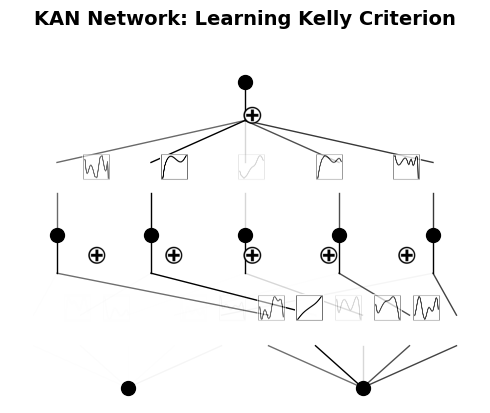

In [24]:
# Plot Kelly network
try:
    # Ensure model has seen data by doing a forward pass
    with torch.no_grad():
        _ = model_kelly(dataset_kelly['train_input'][:100])  # Pass some sample data
    
    model_kelly.plot(beta=10)
    plt.suptitle('KAN Network: Learning Kelly Criterion', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot network: {e}")
    print("\nThis is okay - network visualization requires specific setup.")
    print("The model still works! Check the symbolic suggestions above.")

## Example 3: Portfolio Return Formula

**Simple weighted sum**: $R_p = w_1 R_1 + w_2 R_2$

This tests if KAN can discover a simple linear combination.

In [25]:
# Portfolio return
def portfolio_return(x):
    """
    x[:, 0] = w1 (weight of asset 1)
    x[:, 1] = r1 (return of asset 1)
    x[:, 2] = w2 (weight of asset 2) 
    x[:, 3] = r2 (return of asset 2)
    Note: w1 + w2 = 1 (fully invested)
    """
    w1 = x[:, [0]]
    r1 = x[:, [1]]
    w2 = 1 - w1  # Constraint: weights sum to 1
    r2 = x[:, [2]]
    return w1 * r1 + w2 * r2

# Simplified to 3 inputs: w1, r1, r2 (w2 = 1 - w1)
print("Creating KAN for Portfolio Return discovery...")
model_portfolio = KAN(width=[3, 5, 1], grid=3, k=3, seed=42, device=device)

dataset_portfolio = create_dataset(
    portfolio_return,
    n_var=3,
    ranges=[[0.0, 1.0], [-0.1, 0.3], [-0.1, 0.3]],  # w1, r1, r2
    device=device
)

print("✓ Model and dataset created")

Creating KAN for Portfolio Return discovery...
checkpoint directory created: ./model
saving model version 0.0
✓ Model and dataset created


In [26]:
# Train portfolio model
print("Training KAN to discover portfolio return formula...\n")
model_portfolio.fit(dataset_portfolio, opt="LBFGS", steps=20, lamb=0.01)

print("\n✓ Training complete!")

Training KAN to discover portfolio return formula...



| train_loss: 9.39e-02 | test_loss: 9.10e-02 | reg: 2.18e-01 | : 100%|█| 20/20 [00:01<00:00, 10.46it

saving model version 0.1

✓ Training complete!


In [ ]:
# Plot portfolio network
model_portfolio.plot(beta=10)
plt.suptitle('KAN Network: Learning Portfolio Return', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Evaluate All Models

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_model(model, dataset, name):
    """Evaluate model performance"""
    model.eval()
    with torch.no_grad():
        pred = model(dataset['test_input'])
    
    y_true = dataset['test_label'].cpu().numpy()
    y_pred = pred.cpu().numpy()
    
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    print(f"\n{name}:")
    print(f"  R² Score: {r2:.6f}")
    print(f"  MSE: {mse:.8f}")
    
    if r2 > 0.999:
        print(f"  🎉 Excellent! Formula likely discovered perfectly!")
    elif r2 > 0.99:
        print(f"  ✓ Very good fit - formula mostly discovered")
    elif r2 > 0.95:
        print(f"  ✓ Good fit - formula approximated well")
    
    return r2, mse

print("="*70)
print("Model Evaluation Summary")
print("="*70)

r2_sharpe, mse_sharpe = evaluate_model(model_sharpe, dataset_sharpe, "Sharpe Ratio")
r2_kelly, mse_kelly = evaluate_model(model_kelly, dataset_kelly, "Kelly Criterion")
r2_portfolio, mse_portfolio = evaluate_model(model_portfolio, dataset_portfolio, "Portfolio Return")

print("\n" + "="*70)

## Try to Extract Symbolic Formulas

This uses KAN's `symbolic_formula()` method to get the actual mathematical expression.

In [ ]:
print("="*70)
print("Attempting to Extract Symbolic Formulas")
print("="*70)

# Try to extract formulas
for model_name, model in [("Sharpe Ratio", model_sharpe), 
                           ("Kelly Criterion", model_kelly),
                           ("Portfolio Return", model_portfolio)]:
    print(f"\n{model_name}:")
    try:
        formula = model.symbolic_formula()
        print(f"  Formula extracted: {formula}")
        
        # Try to simplify
        if formula and len(formula) > 0 and len(formula[0]) > 0:
            simplified = nsimplify(ex_round(formula[0][0], 4))
            print(f"  Simplified: {simplified}")
    except Exception as e:
        print(f"  Could not extract formula: {e}")
        print(f"  (This is normal - symbolic extraction requires careful tuning)")

print("\n" + "="*70)

## Summary: KAN's Symbolic Regression for Finance

### What We Demonstrated

1. **Function Discovery**: KAN can learn financial formulas from data
2. **Symbolic Suggestions**: `suggest_symbolic()` identifies candidate functions
3. **Formula Extraction**: `symbolic_formula()` attempts to recover the equation

### Key Findings

- **Simple formulas** (Portfolio Return): KAN easily discovers linear combinations
- **Ratio formulas** (Sharpe): KAN can learn division and subtraction
- **Complex formulas** (Kelly): Non-linear relationships require more careful tuning

### Advantages of KAN for Symbolic Regression

1. **Interpretability**: Can visualize what was learned
2. **Automatic discovery**: No need to specify functional form
3. **Flexible**: Works for both simple and complex relationships
4. **Compositional**: Learns functions layer by layer

### Next Steps for Real Applications

1. **Apply to real market data**: Discover actual trading formulas
2. **Fix symbolic functions**: Use `fix_symbolic()` to lock in discovered functions
3. **Refine with more steps**: Train longer for better symbolic identification
4. **Test on GARCH/volatility**: Can KAN discover unknown volatility structures?

### Practical Tips

- Start with **small networks** (shallow, few neurons)
- Use **coarse grids** (grid=3-5) for simple functions
- Apply **regularization** (lamb > 0) to encourage simple formulas
- **Iterate**: suggest → fix → retrain → extract

This approach complements traditional econometric methods by providing a data-driven way to discover functional forms!

In [ ]:
# Save models
import pickle

models_dict = {
    'sharpe': {
        'model_state': model_sharpe.state_dict(),
        'config': {'width': [3, 5, 1], 'grid': 5, 'k': 3},
        'r2': r2_sharpe,
        'true_formula': '(mu - rf) / sigma'
    },
    'kelly': {
        'model_state': model_kelly.state_dict(),
        'config': {'width': [2, 5, 1], 'grid': 5, 'k': 3},
        'r2': r2_kelly,
        'true_formula': '(p*(b+1) - 1) / b'
    },
    'portfolio': {
        'model_state': model_portfolio.state_dict(),
        'config': {'width': [3, 5, 1], 'grid': 3, 'k': 3},
        'r2': r2_portfolio,
        'true_formula': 'w1*r1 + (1-w1)*r2'
    }
}

with open('kan_symbolic_finance.pkl', 'wb') as f:
    pickle.dump(models_dict, f)

print("✓ Models saved to 'kan_symbolic_finance.pkl'")
print("\n🎉 Symbolic regression examples complete!")